In [1]:
import connectors.snowflake as snowflake

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xlrd
import pandas_profiling as pp
from scipy import stats
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [16]:
deposit_balance_sql = """
use role prod_revenue_analyst;
use database prod_skillz_primary;
use warehouse PROD_ANALYTICS_ADHOC;

--For users with a low balance (<$1), give an LTO of varying sizes based on their historical transaction sizes. 
--Perform EDA to look at how far back we should look for average historical deposits (D3, D7, D14?), depends on how often users deposit.

/*
1) Understand when users are making deposits? at what balance level do users making deposits?
2) Deposit Amount vs. Users Last 1,3,7,14-day or Total Deposits deposit amount 
3) correlation - deposit amount 
    1) Non-depositor
    2) Low <30
    3) > 30
*/

With User_List as (
    select
        du.id as user_id,
        du.date_created as account_creation_date,
        du.first_deposit_datetime,
        du.total_deposits,
        du.total_entry_fees
  from corp_mart.dim_user du 
  inner join skillz.sec_user su
        on du.id = su.id
        and su.enabled = 1 -- not disabled
        and su.quarantined = 0 -- not quarantined
    where
        true
        and du.date_created   
            between '2021-01-01 00:00:00' and '2021-09-15 00:00:00'
        AND user_id not in (select user_id from archive.staff_users)
        and first_deposit_datetime is not null
        and profitability <= 30
 GROUP BY 1,2,3,4,5
) 
, deposits as (select 
    ul.user_id
    ,pt.id as pt_id
    ,pt.date
    ,account_creation_date
    ,first_deposit_datetime
    ,any_value(total_deposits) as total_deposits
    ,any_value(total_entry_fees) as total_entry_fees
    ,any_value(balance - amount) as balance_when_deposit
    ,any_value(amount) as deposit
    ,rank() over (partition by ul.user_id order by ul.user_id, pt.date) as dep_rnk

FROM user_list ul
inner join archive.payment_transaction pt
        on ul.user_id::varchar = pt.user_id
        and pt.transaction_type in (0) and pt.date  >= '2021-01-01 00:00:00' 
   --     and pt.date >= ul.first_deposit_datetime
group by 1,2,3,4,5)

/*,most_played as (

    select user_id, 
        tt.id,
            count(tp.id) over (partition by user_id, tt.id) 

        FROM user_list ul
    left join skillz.tournament_player as tp on ul.user_id = tp.user_id
        and tp.date_created >= '2021-01-01 00:00:00' 
    join skillz.tournament_template as tt on tp.TOURNAMENT_TEMPLATE_ID = tt.id
    and tt.entry_fee > 0 
    
)*/

---, entry_fee_status as (
    select 
        d.user_id
        ,d.pt_id
        ,d.date
        ,d.balance_when_deposit
        ,d.deposit
        ,account_creation_date
        ,first_deposit_datetime
        ,case when dep_rnk <= 10 then dep_rnk else '11' end as dep_rnk
        ,any_value(total_deposits) as total_deposits
        ,any_value(total_entry_fees) as total_entry_fees

        ,SUM(case when transaction_type = 2 and pt2.date between dateadd('day',-3, d.date) and d.date then -pt2.amount else 0 end)/COUNT(DISTINCT CASE WHEN transaction_type = 2 and pt2.date between dateadd('day',-3, d.date) and d.date then pt2.id else 0 end) as Avg_EF_Last_3D
        ,SUM(case when transaction_type = 2 and pt2.date between dateadd('day',-7, d.date) and d.date then -pt2.amount else 0 end)/COUNT(DISTINCT CASE WHEN transaction_type = 2 and pt2.date between dateadd('day',-7, d.date) and d.date then pt2.id else 0 end) as Avg_EF_Last_7D
        ,SUM(case when transaction_type = 2 and pt2.date between dateadd('day',-14, d.date) and d.date then -pt2.amount else 0 end)/COUNT(DISTINCT CASE WHEN transaction_type = 2 and pt2.date between dateadd('day',-14, d.date) and d.date then pt2.id else 0 end) as Avg_EF_Last_14D    
        ,SUM(case when transaction_type = 0 and pt2.date between dateadd('day',-3, d.date) and d.date then -pt2.amount else 0 end) as Avg_Depo_Last_3D
        ,SUM(case when transaction_type = 0 and pt2.date between dateadd('day',-7, d.date) and d.date then -pt2.amount else 0 end) as Avg_Depo_Last_7D
        ,SUM(case when transaction_type = 0 and pt2.date between dateadd('day',-14, d.date) and d.date then -pt2.amount else 0 end) as Avg_Depo_Last_14D
 
 
 --,count(distinct case when pt.amount )
  
    from deposits as d
    left join archive.payment_transaction pt2
        on d.user_id::varchar = pt2.user_id
            and pt2.transaction_type in (0,2) and pt2.date  >= '2021-01-01 00:00:00' 
      group by 1,2,3,4,5,6,7 ,8
  
  ;

"""

In [17]:
with snowflake.Connection('prod',role='prod_revenue_analyst', warehouse = 'PROD_ANALYTICS_ADHOC', is_remote=True) as conn:
    deposit_balance_df = snowflake.run_statements(deposit_balance_sql, conn)

In [18]:
deposit_balance_df.head()

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D
0,64052451,6073239322,2021-01-25 15:47:47,0.60,20.0,2021-01-04 00:14:56,2021-01-04 00:25:34,11,1222.0,8920.00,6.164602,4.254450,3.159451,-100.0,-150.0,-260.0
1,68781509,6694028496,2021-04-02 05:33:55,3.49,5.0,2021-02-26 11:12:29,2021-02-26 14:47:37,6,147.0,996.25,1.395833,1.072917,0.991379,-15.0,-30.0,-30.0
2,65998812,6287945381,2021-02-17 03:50:40,0.25,20.0,2021-01-25 01:33:23,2021-01-25 02:25:41,11,440.0,2197.80,0.000000,0.584615,0.649693,-20.0,-20.0,-80.0
3,75729580,7425838024,2021-06-25 04:43:11,0.50,5.0,2021-06-07 04:54:48,2021-06-07 04:59:41,8,152.0,971.80,0.696154,0.885068,0.885068,-30.0,-35.0,-35.0
4,80003113,8080399160,2021-09-03 09:54:02,4.00,20.0,2021-07-31 04:04:42,2021-07-31 04:26:02,11,4300.0,37113.80,11.934066,14.953061,17.996491,-160.0,-440.0,-830.0


In [390]:
deposit_balance_df_0 = deposit_balance_df[~(deposit_balance_df.PT_ID.isna())]


In [49]:
#deposit_balance_df_0['PT_ID'] = deposit_balance_df_0['PT_ID'].astype('int')
#deposit_balance_df_0['dep_rank'] = deposit_balance_df_0['dep_rank'].astype('float')
deposit_balance_df['AVG_DEPO_LAST_3D'] = deposit_balance_df.AVG_DEPO_LAST_3D*(-1)

deposit_balance_df['AVG_DEPO_LAST_7D'] = deposit_balance_df.AVG_DEPO_LAST_7D*(-1)
deposit_balance_df['AVG_DEPO_LAST_14D'] = deposit_balance_df.AVG_DEPO_LAST_14D*(-1)

In [50]:
deposit_balance_df.sort_values(by=['USER_ID','DATE'],ascending = True).head(50)

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D
4007156,63752992,5862724515,2021-01-03 18:39:40,0.00,10.0,2021-01-01 00:00:13,2021-01-03 18:39:40,1,80.0,395.70,0.000000,0.000000,0.000000,10.0,10.0,10.0
2931137,63752992,5863893209,2021-01-03 21:01:48,1.60,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,2,80.0,395.70,3.600000,3.600000,3.600000,40.0,40.0,40.0
705336,63752992,5864080313,2021-01-03 21:24:59,2.20,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,3,80.0,395.70,3.842308,3.842308,3.842308,70.0,70.0,70.0
863926,63752992,5880964791,2021-01-05 14:02:07,0.25,10.0,2021-01-01 00:00:13,2021-01-03 18:39:40,4,80.0,395.70,3.781250,3.781250,3.781250,80.0,80.0,80.0
3510209,63753020,5866990926,2021-01-04 02:41:05,0.00,50.0,2021-01-01 00:00:45,2021-01-04 02:41:05,1,130.0,754.85,0.000000,0.000000,0.000000,50.0,50.0,50.0
3670270,63753020,5934446259,2021-01-11 02:33:47,0.22,20.0,2021-01-01 00:00:45,2021-01-04 02:41:05,2,130.0,754.85,4.260274,3.748000,3.748000,20.0,70.0,70.0
1843564,63753020,5945154039,2021-01-12 04:40:51,0.45,50.0,2021-01-01 00:00:45,2021-01-04 02:41:05,3,130.0,754.85,2.286552,2.731731,2.642416,70.0,70.0,120.0
891305,63753020,8068644122,2021-09-02 03:19:06,0.03,10.0,2021-01-01 00:00:45,2021-01-04 02:41:05,4,130.0,754.85,0.080000,0.080000,0.080000,10.0,10.0,10.0
3819140,63753060,5915247403,2021-01-09 03:09:06,0.19,2.0,2021-01-01 00:01:24,2021-01-09 03:09:06,1,7.0,93.85,0.000000,0.239583,0.239583,2.0,2.0,2.0
1038131,63753060,8409175688,2021-10-02 20:10:55,0.05,5.0,2021-01-01 00:01:24,2021-01-09 03:09:06,2,7.0,93.85,0.000000,0.000000,0.080000,5.0,5.0,5.0


In [52]:
deposit_balance_df.USER_ID.nunique()

1150390

In [53]:
## last 3d ef

deposit_balance_df[deposit_balance_df.DEP_RNK>1].AVG_EF_LAST_3D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    3028194.000000
mean           2.948992
std            8.286618
min            0.000000
10%            0.000000
20%            0.525000
30%            0.704000
40%            0.989286
50%            1.361501
60%            1.753846
70%            2.292000
80%            3.212727
90%            5.605483
max          453.375000
Name: AVG_EF_LAST_3D, dtype: object

In [54]:
## last 7d ef
deposit_balance_df.AVG_EF_LAST_7D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    4178588.000000
mean           2.249493
std            6.954028
min            0.000000
10%            0.000000
20%            0.000000
30%            0.000000
40%            0.596450
50%            0.900000
60%            1.332000
70%            1.830704
80%            2.630986
90%            4.542857
max          349.145455
Name: AVG_EF_LAST_7D, dtype: object

In [55]:
deposit_balance_df.AVG_EF_LAST_14D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    4178588.000000
mean           2.278075
std            6.662301
min            0.000000
10%            0.000000
20%            0.000000
30%            0.261111
40%            0.664368
50%            0.986047
60%            1.410051
70%            1.898395
80%            2.700000
90%            4.588166
max          378.779747
Name: AVG_EF_LAST_14D, dtype: object

In [56]:
# users deposit amount

deposit_balance_df[deposit_balance_df.DEP_RNK>1].DEPOSIT.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format)

count    3028194.000000
mean          19.053033
std           38.618823
min            1.000000
10%            5.000000
20%            5.000000
30%           10.000000
40%           10.000000
50%           10.000000
60%           10.000000
70%           20.000000
80%           20.000000
90%           30.000000
max         1000.000000
Name: DEPOSIT, dtype: object

In [57]:
# Last 3D Deposits

deposit_balance_df[deposit_balance_df.DEP_RNK>1].AVG_DEPO_LAST_3D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    3028194.000000
mean          72.165051
std          283.846035
min            2.000000
10%            6.000000
20%           10.000000
30%           14.000000
40%           20.000000
50%           20.000000
60%           30.000000
70%           45.000000
80%           70.000000
90%          130.000000
max        24000.000000
Name: AVG_DEPO_LAST_3D, dtype: object

In [58]:
# Last 7D Deposits

deposit_balance_df[deposit_balance_df.DEP_RNK>1].AVG_DEPO_LAST_7D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    3028194.000000
mean         124.603660
std          528.731492
min            2.000000
10%           10.000000
20%           12.000000
30%           20.000000
40%           25.000000
50%           35.000000
60%           50.000000
70%           70.000000
80%          115.000000
90%          230.000000
max        33000.000000
Name: AVG_DEPO_LAST_7D, dtype: object

In [59]:
# Last 14D Deposits

deposit_balance_df[deposit_balance_df.DEP_RNK>1].AVG_DEPO_LAST_14D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format) 

count    3028194.000000
mean         202.289007
std          916.224775
min            2.000000
10%           10.000000
20%           17.000000
30%           25.000000
40%           35.000000
50%           50.000000
60%           70.000000
70%          110.000000
80%          180.000000
90%          375.000000
max        48700.000000
Name: AVG_DEPO_LAST_14D, dtype: object

In [60]:
## users balance when they make a deposit (% users)

deposit_balance_df[deposit_balance_df.DEP_RNK>1].BALANCE_WHEN_DEPOSIT.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).map('{:.6f}'.format)

count    3028194.000000
mean           4.556050
std           49.506537
min            0.000000
10%            0.050000
20%            0.170000
30%            0.230000
40%            0.360000
50%            0.420000
60%            0.550000
70%            1.100000
80%            2.100000
90%            6.200000
max         9772.200000
Name: BALANCE_WHEN_DEPOSIT, dtype: object

In [433]:
### Group Users by their "Last 3d avg EF"

deposit_balance_df_categorized =  pd.DataFrame(deposit_balance_df[deposit_balance_df.DEP_RNK>1])

condition_3Day = [
    (deposit_balance_df_categorized['AVG_EF_LAST_3D'] <= 3),
    (deposit_balance_df_categorized['AVG_EF_LAST_3D'] <= 3), 
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 2 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 3 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 4 ),    
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 5 ),    
    (deposit_balance_df_categorized['AVG_EF_LAST_3D'] > 3 )
]
values_3Day = ['<=1','1~3','3+']

deposit_balance_df_categorized['D3_Avg_EF'] = np.select(condition_3Day, values_3Day)


In [444]:
### Group Users by their "Last 7d avg EF"

deposit_balance_df_categorized =  pd.DataFrame(deposit_balance_df[deposit_balance_df.DEP_RNK>1])

condition_7Day = [
    (deposit_balance_df_categorized['AVG_EF_LAST_7D'] <= 1),
    (deposit_balance_df_categorized['AVG_EF_LAST_7D'] <= 3), 
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 2 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 3 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 4 ),    
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 5 ),    
    (deposit_balance_df_categorized['AVG_EF_LAST_7D'] > 3 )
]
values_7Day = ['<=1','1~3','3+']

deposit_balance_df_categorized['D7_Avg_EF'] = np.select(condition_7Day, values_7Day)

In [448]:
### Group Users by their "Last 14d avg EF"

deposit_balance_df_categorized =  pd.DataFrame(deposit_balance_df[deposit_balance_df.DEP_RNK>1])

condition_14Day = [
    (deposit_balance_df_categorized['AVG_EF_LAST_14D'] <= 1),
    (deposit_balance_df_categorized['AVG_EF_LAST_14D'] <= 3), 
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 2 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 3 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 4 ),    
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 5 ),    
    (deposit_balance_df_categorized['AVG_EF_LAST_14D'] > 3 )
]
values_14Day = ['<=1','1~3','3+']

deposit_balance_df_categorized['D14_Avg_EF'] = np.select(condition_14Day, values_14Day)


In [452]:
deposit_balance_df_categorized.head()

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,D3_Avg_EF,D14_Avg_EF
0,75586830,7532104252,2021-07-07 02:11:54,1.51,10.0,2021-06-05 02:57:47,2021-06-05 03:05:58,30,680.0,1782.60,1.547368,1.224561,1.125212,100.0,140.0,170.0,1~3,1~3
1,67357751,6565033995,2021-03-18 19:34:01,0.19,5.0,2021-02-10 04:30:40,2021-03-16 23:39:15,2,7.0,238.05,0.247159,0.247159,0.247685,7.0,7.0,7.0,<=1,<=1
2,68677340,8046950157,2021-08-30 22:28:18,6.50,50.0,2021-02-25 02:05:36,2021-02-25 02:15:55,63,2520.0,12003.10,2.112571,2.005023,1.974540,130.0,280.0,350.0,1~3,1~3
3,65850461,6355989876,2021-02-24 08:17:59,0.55,10.0,2021-01-23 08:24:42,2021-01-25 19:33:51,11,155.0,1059.00,0.000000,1.636364,1.433071,10.0,20.0,90.0,<=1,1~3
4,65422922,6550127599,2021-03-17 03:20:50,0.45,10.0,2021-01-18 13:42:34,2021-01-20 23:42:17,9,115.0,421.10,0.533333,0.585000,0.590909,10.0,10.0,20.0,<=1,<=1


In [456]:
deposit_balance_sub_df = deposit_balance_df_categorized.drop(columns = ['DATE', 'PT_ID','ACCOUNT_CREATION_DATE','FIRST_DEPOSIT_DATETIME'])
deposit_balance_sub_df.head()

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,D3_Avg_EF,D14_Avg_EF
0,75586830,1.51,10.0,30,680.0,1782.60,1.547368,1.224561,1.125212,100.0,140.0,170.0,1~3,1~3
1,67357751,0.19,5.0,2,7.0,238.05,0.247159,0.247159,0.247685,7.0,7.0,7.0,<=1,<=1
2,68677340,6.50,50.0,63,2520.0,12003.10,2.112571,2.005023,1.974540,130.0,280.0,350.0,1~3,1~3
3,65850461,0.55,10.0,11,155.0,1059.00,0.000000,1.636364,1.433071,10.0,20.0,90.0,<=1,1~3
4,65422922,0.45,10.0,9,115.0,421.10,0.533333,0.585000,0.590909,10.0,10.0,20.0,<=1,<=1


In [457]:
deposit_balance_sub_agg_3D = deposit_balance_sub_df.groupby(by=['D3_Avg_EF']).agg({'USER_ID':'count','BALANCE_WHEN_DEPOSIT':'median','DEPOSIT':'mean','TOTAL_DEPOSITS':'median'})
deposit_balance_sub_agg_3D['pct_user_of_total'] = deposit_balance_sub_agg_3D['USER_ID'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)
deposit_balance_sub_agg_3D.sort_values(by=['pct_user_of_total'], ascending = False)

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,TOTAL_DEPOSITS,pct_user_of_total
D3_Avg_EF,,,,,
<=1,1211367,0.40,11.531523,90.0,0.404230
1~3,1136531,0.44,14.970948,320.0,0.379258
3+,648828,1.00,40.168891,1465.0,0.216512


In [441]:
deposit_balance_sub_agg_7D = deposit_balance_sub_df.groupby(by=['D7_Avg_EF']).agg({'USER_ID':'count','BALANCE_WHEN_DEPOSIT':'median','DEPOSIT':'mean'})
deposit_balance_sub_agg_7D['pct_user_of_total'] = deposit_balance_sub_agg_7D['USER_ID'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)
deposit_balance_sub_agg_7D.sort_values(by=['pct_user_of_total'], ascending = False)

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,pct_user_of_total
D7_Avg_EF,,,,
1~3,1247013,0.4,14.629119,0.417751
<=1,1043965,0.4,10.979504,0.349729
3+,694087,0.9,39.024436,0.232520


In [445]:
deposit_balance_sub_agg_14D = deposit_balance_sub_df.groupby(by=['D14_Avg_EF']).agg({'USER_ID':'count','BALANCE_WHEN_DEPOSIT':'mean','DEPOSIT':'mean'})
deposit_balance_sub_agg_14D['pct_user_of_total'] = deposit_balance_sub_agg_14D['USER_ID'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)
deposit_balance_sub_agg_14D.sort_values(by=['pct_user_of_total'], ascending = False)

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,pct_user_of_total
D14_Avg_EF,,,,
1~3,1320684,2.705247,14.524580,0.442431
<=1,950445,3.584294,10.586657,0.318400
3+,713936,9.317210,38.584494,0.239169


In [458]:
deposit_balance_sub_df.head()

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,D3_Avg_EF,D14_Avg_EF
0,75586830,1.51,10.0,30,680.0,1782.60,1.547368,1.224561,1.125212,100.0,140.0,170.0,1~3,1~3
1,67357751,0.19,5.0,2,7.0,238.05,0.247159,0.247159,0.247685,7.0,7.0,7.0,<=1,<=1
2,68677340,6.50,50.0,63,2520.0,12003.10,2.112571,2.005023,1.974540,130.0,280.0,350.0,1~3,1~3
3,65850461,0.55,10.0,11,155.0,1059.00,0.000000,1.636364,1.433071,10.0,20.0,90.0,<=1,1~3
4,65422922,0.45,10.0,9,115.0,421.10,0.533333,0.585000,0.590909,10.0,10.0,20.0,<=1,<=1


In [459]:
## Avg Last 3D EF, <=1
deposit_balance_sub_3D_1 = deposit_balance_sub_df[(deposit_balance_sub_df.D3_Avg_EF == "<=1") & (deposit_balance_sub_df.BALANCE_WHEN_DEPOSIT <=7)]
deposit_balance_sub_3D_1.head()

,USER_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,D3_Avg_EF,D14_Avg_EF
1,67357751,0.19,5.0,2,7.0,238.05,0.247159,0.247159,0.247685,7.0,7.0,7.0,<=1,<=1
3,65850461,0.55,10.0,11,155.0,1059.00,0.000000,1.636364,1.433071,10.0,20.0,90.0,<=1,1~3
4,65422922,0.45,10.0,9,115.0,421.10,0.533333,0.585000,0.590909,10.0,10.0,20.0,<=1,<=1
5,66680662,2.00,10.0,6,895.0,4781.60,0.881633,1.280000,1.538217,10.0,25.0,65.0,<=1,1~3
6,73971778,0.55,10.0,14,265.0,1809.90,0.687179,0.869919,0.871605,10.0,30.0,40.0,<=1,<=1


In [460]:
deposit_balance_sub_df_cor = deposit_balance_sub_df.drop(columns = ['USER_ID','TOTAL_DEPOSITS','TOTAL_ENTRY_FEES'])


In [461]:
deposit_balance_sub_df_cor.corr()

,BALANCE_WHEN_DEPOSIT,DEPOSIT,DEP_RNK,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D
BALANCE_WHEN_DEPOSIT,1.000000,0.171580,0.034347,0.159330,0.153929,0.147441,0.199883,0.175094,0.158441
DEPOSIT,0.171580,1.000000,0.161051,0.562708,0.562255,0.554847,0.581461,0.550113,0.522327
DEP_RNK,0.034347,0.161051,1.000000,0.315345,0.331124,0.344384,0.293590,0.332553,0.363947
AVG_EF_LAST_3D,0.159330,0.562708,0.315345,1.000000,0.955696,0.914404,0.765946,0.763291,0.746775
AVG_EF_LAST_7D,0.153929,0.562255,0.331124,0.955696,1.000000,0.967055,0.734111,0.772340,0.768718
AVG_EF_LAST_14D,0.147441,0.554847,0.344384,0.914404,0.967055,1.000000,0.705664,0.748983,0.777880
AVG_DEPO_LAST_3D,0.199883,0.581461,0.293590,0.765946,0.734111,0.705664,1.000000,0.920171,0.856209
AVG_DEPO_LAST_7D,0.175094,0.550113,0.332553,0.763291,0.772340,0.748983,0.920171,1.000000,0.949127
AVG_DEPO_LAST_14D,0.158441,0.522327,0.363947,0.746775,0.768718,0.777880,0.856209,0.949127,1.000000


In [ ]:
pd.scdeposit_balance_sub_df_cor

In [81]:
### Group Users by their "Last 14d avg EF"

balance_when_deposit =  pd.DataFrame(deposit_balance_df_0)

condition_1 = [
    (balance_when_deposit['BALANCE_WHEN_DEPOSIT'] <= 0.6),
    (balance_when_deposit['BALANCE_WHEN_DEPOSIT'] <= 1), 
         (balance_when_deposit['BALANCE_WHEN_DEPOSIT'] <= 1.8), 
    (balance_when_deposit['BALANCE_WHEN_DEPOSIT'] > 1.8  )
]
values_1 = ['<=0.6','0.6~1','1~1.8','1.8+']
#values_1 = ['<=0.6','0.6+']

balance_when_deposit['Account_Balance_Agg'] = np.select(condition_1, values_1)
balance_when_deposit_agg = balance_when_deposit.groupby(by=['Account_Balance_Agg']).agg({'USER_ID':'nunique',
'BALANCE_WHEN_DEPOSIT':'median','AVG_EF_LAST_3D':'median','DEPOSIT':'mean','AVG_EF_LAST_7D':'median','AVG_EF_LAST_14D':'median','AVG_DEPO_LAST_3D':'median','AVG_DEPO_LAST_7D':'median','AVG_DEPO_LAST_14D':'median','TOTAL_DEPOSITS':'mean'})


balance_when_deposit_agg['pct_user_of_total'] = balance_when_deposit_agg['USER_ID'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)
balance_when_deposit_agg=balance_when_deposit_agg.rename({'USER_ID':'User_count','BALANCE_WHEN_DEPOSIT':'Avg Balance when Deposit'}, axis=1)
balance_when_deposit_agg.sort_values(by=['pct_user_of_total'], ascending = False)

#balance_when_deposit_agg = balance_when_deposit_agg.append(balance_when_deposit.groupby(by=['Account_Balance_Agg']).agg({'BALANCE_WHEN_DEPOSIT':'mean','AVG_EF_LAST_3D':'mean','DEPOSIT':'mean','AVG_EF_LAST_7D':'mean','AVG_EF_LAST_14D':'mean','DEPOSIT':'mean'})



,User_count,Avg Balance when Deposit,AVG_EF_LAST_3D,DEPOSIT,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,TOTAL_DEPOSITS,pct_user_of_total
Account_Balance_Agg,,,,,,,,,,,
<=0.6,353133,0.25,1.095238,14.327904,1.290588,1.388462,20.0,30.0,40.0,942.009604,0.473626
1.8+,207746,5.40,2.000000,31.767635,2.057143,2.060870,40.0,55.0,70.0,3254.182759,0.278632
1~1.8,106807,1.40,1.898779,20.461787,2.001929,2.040966,30.0,50.0,70.0,1698.246652,0.143251
0.6~1,77908,0.80,1.895122,20.215702,2.000000,2.043662,30.0,45.0,65.0,1704.191025,0.104491


In [85]:
deposit_balance_df_0.AVG_DEPO_LAST_7D.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7,.73,.75,.78, .8,.83,.85,.87, .9,.93,.96,.99]).map('{:.6f}'.format)

count    2985065.000000
mean         124.228510
std          527.560034
min            2.000000
10%           10.000000
20%           12.000000
30%           20.000000
40%           25.000000
50%           35.000000
60%           50.000000
70%           70.000000
73%           80.000000
75%           90.000000
78%          100.000000
80%          115.000000
83%          140.000000
85%          155.000000
87%          180.000000
90%          230.000000
93%          310.000000
96%          500.000000
99%         1450.000000
max        33000.000000
Name: AVG_DEPO_LAST_7D, dtype: object

In [86]:
### Group Users by their "Last 14d avg Deposits"

deposit_balance_df_by_7d_deposit =  pd.DataFrame(deposit_balance_df_0)
deposit_balance_df_by_7d_deposit['month'] = pd.DatetimeIndex(deposit_balance_df_by_7d_deposit['DATE']).month


In [87]:
deposit_balance_df_by_7d_deposit[deposit_balance_df_by_7d_deposit.month ==9].USER_ID.nunique()

98378

In [232]:


condition_7DayDe = [
    (deposit_balance_df_categorized['AVG_DEPO_LAST_7D'] <= 15),
#     (deposit_balance_df_categorized['AVG_DEPO_LAST_7D'] <= 30), 
#     #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 2 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 3 ),
    #(deposit_balance_df_categorized['AVG_EF_LAST_3D'] == 4 ),    
    (deposit_balance_df_categorized['AVG_DEPO_LAST_7D'] <= 30 ),    
    (deposit_balance_df_categorized['AVG_DEPO_LAST_7D'] > 30 )
]
values_7DayDe = ['<=15','15~30','30+']
#values_7DayDe = ['<=15','15+']

deposit_balance_df_by_7d_deposit['D7_Avg_Deposit'] = np.select(condition_7DayDe, values_7DayDe)
deposit_balance_df_by_7d_deposit_agg = deposit_balance_df_by_7d_deposit[deposit_balance_df_by_7d_deposit.month ==9].groupby(by=['D7_Avg_Deposit']).agg({'USER_ID':'count',
'BALANCE_WHEN_DEPOSIT':'median','AVG_EF_LAST_3D':'median','DEPOSIT':'mean','AVG_EF_LAST_7D':'median','AVG_EF_LAST_14D':'median',
'AVG_DEPO_LAST_3D':'median','AVG_DEPO_LAST_7D':'median','AVG_DEPO_LAST_14D':'median','TOTAL_DEPOSITS':'mean'})


deposit_balance_df_by_7d_deposit_agg['pct_user_of_total_deposits'] = deposit_balance_df_by_7d_deposit_agg['USER_ID'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)
deposit_balance_df_by_7d_deposit_agg['User_Count'] =deposit_balance_df_by_7d_deposit.groupby(by=['D7_Avg_Deposit']).agg({'USER_ID':'nunique'})
deposit_balance_df_by_7d_deposit_agg['pct_user_of_users'] = deposit_balance_df_by_7d_deposit_agg['User_Count'].transform(lambda x: x/x.sum()).map('{:.6f}'.format)

deposit_balance_df_by_7d_deposit_agg=deposit_balance_df_by_7d_deposit_agg.rename({'USER_ID':'Depo_Count','BALANCE_WHEN_DEPOSIT':'Avg Balance when Deposit'}, axis=1)
#deposit_balance_df_by_7d_deposit_agg.sort_values(by=['pct_user_of_users'], ascending = False)

#balance_when_deposit_agg = balance_when_deposit_agg.append(balance_when_deposit.groupby(by=['Account_Balance_Agg']).agg({'BALANCE_WHEN_DEPOSIT':'mean','AVG_EF_LAST_3D':'mean','DEPOSIT':'mean','AVG_EF_LAST_7D':'mean','AVG_EF_LAST_14D':'mean','DEPOSIT':'mean'})
deposit_balance_df_by_7d_deposit_agg

,Depo_Count,Avg Balance when Deposit,AVG_EF_LAST_3D,DEPOSIT,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,TOTAL_DEPOSITS,pct_user_of_total_deposits,User_Count,pct_user_of_users
D7_Avg_Deposit,,,,,,,,,,,,,
15~30,82023,0.4,0.960000,12.583897,1.212500,1.333333,20.0,20.0,30.0,320.278666,0.208826,240319,0.321773
30+,209182,0.5,2.505298,29.791043,2.687175,2.687067,60.0,100.0,150.0,2896.049378,0.532565,163421,0.218811
<=15,101577,0.4,0.500000,6.648346,0.605844,0.762857,10.0,10.0,10.0,118.310700,0.258609,343118,0.459415


In [233]:
deposit_balance_df.sort_values(by=['USER_ID','DATE'], ascending = True).head(20)

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,dep_rank
653591,63752992,5.863893e+09,2021-01-03 21:01:48,1.60,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,80.0,395.70,3.600000,3.600000,3.600000,40.0,-40.0,-40.0,3.0
2227889,63752992,5.864080e+09,2021-01-03 21:24:59,2.20,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,80.0,395.70,3.842308,3.842308,3.842308,70.0,-70.0,-70.0,2.0
3262346,63752992,5.880965e+09,2021-01-05 14:02:07,0.25,10.0,2021-01-01 00:00:13,2021-01-03 18:39:40,80.0,395.70,3.781250,3.781250,3.781250,80.0,-80.0,-80.0,1.0
2655870,63753020,5.934446e+09,2021-01-11 02:33:47,0.22,20.0,2021-01-01 00:00:45,2021-01-04 02:41:05,130.0,754.85,4.260274,3.748000,3.748000,20.0,-70.0,-70.0,3.0
1504251,63753020,5.945154e+09,2021-01-12 04:40:51,0.45,50.0,2021-01-01 00:00:45,2021-01-04 02:41:05,130.0,754.85,2.286552,2.731731,2.642416,70.0,-70.0,-120.0,2.0
2099130,63753020,8.068644e+09,2021-09-02 03:19:06,0.03,10.0,2021-01-01 00:00:45,2021-01-04 02:41:05,130.0,754.85,0.080000,0.080000,0.080000,10.0,-10.0,-10.0,1.0
225337,63753060,8.409176e+09,2021-10-02 20:10:55,0.05,5.0,2021-01-01 00:01:24,2021-01-09 03:09:06,7.0,93.85,0.000000,0.000000,0.080000,5.0,-5.0,-5.0,1.0
2393434,63753084,7.154726e+09,2021-05-24 22:12:54,0.15,10.0,2021-01-01 00:01:51,2021-01-02 04:53:10,92.0,1265.10,0.300000,0.720000,0.675000,10.0,-10.0,-10.0,9.0
3394990,63753084,7.155170e+09,2021-05-24 23:16:05,0.55,5.0,2021-01-01 00:01:51,2021-01-02 04:53:10,92.0,1265.10,1.593103,1.537500,1.457143,15.0,-15.0,-15.0,8.0
1983914,63753084,7.180160e+09,2021-05-27 23:59:20,0.15,5.0,2021-01-01 00:01:51,2021-01-02 04:53:10,92.0,1265.10,1.238095,1.350000,1.335849,5.0,-20.0,-20.0,7.0


In [19]:
deposit_balance_df = pd.DataFrame(deposit_balance_df)

In [20]:
deposit_balance_df_by_depo_count.head()

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D
0,64052451,6073239322,2021-01-25 15:47:47,0.60,20.0,2021-01-04 00:14:56,2021-01-04 00:25:34,11,1222.0,8920.00,6.164602,4.254450,3.159451,-100.0,-150.0,-260.0
1,68781509,6694028496,2021-04-02 05:33:55,3.49,5.0,2021-02-26 11:12:29,2021-02-26 14:47:37,6,147.0,996.25,1.395833,1.072917,0.991379,-15.0,-30.0,-30.0
2,65998812,6287945381,2021-02-17 03:50:40,0.25,20.0,2021-01-25 01:33:23,2021-01-25 02:25:41,11,440.0,2197.80,0.000000,0.584615,0.649693,-20.0,-20.0,-80.0
3,75729580,7425838024,2021-06-25 04:43:11,0.50,5.0,2021-06-07 04:54:48,2021-06-07 04:59:41,8,152.0,971.80,0.696154,0.885068,0.885068,-30.0,-35.0,-35.0
4,80003113,8080399160,2021-09-03 09:54:02,4.00,20.0,2021-07-31 04:04:42,2021-07-31 04:26:02,11,4300.0,37113.80,11.934066,14.953061,17.996491,-160.0,-440.0,-830.0


In [25]:
Multi_depositor = deposit_balance_df_by_depo_count[deposit_balance_df_by_depo_count.DEP_RNK>1].USER_ID.nunique()

In [26]:
Total_depositor = deposit_balance_df_by_depo_count[deposit_balance_df_by_depo_count.DEP_RNK==1].USER_ID.nunique()

In [201]:
round(100*(Multi_depositor/Total_depositor),2)

39.8

In [42]:
str(round(100*(1-Multi_depositor/Total_depositor),2))+"%"

'60.2%'

In [228]:
data = [round((Multi_depositor/Total_depositor),2),round((1-Multi_depositor/Total_depositor),2)]
pect_multi_depositors = pd.Series(data, index=['multi_depositor','one_time_depositor'])
pect_multi_depositors_df = pd.DataFrame(pect_multi_depositors, columns=['pect_2021_npu'])

pect_multi_depositors_df

,pect_2021_npu
multi_depositor,0.4
one_time_depositor,0.6


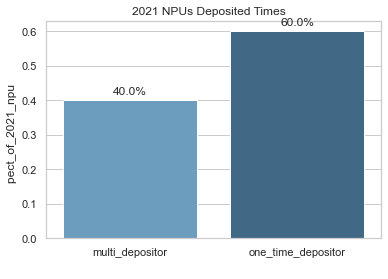

In [229]:

sns.set_theme(style="whitegrid")
plot = sns.barplot(y= 'pect_2021_npu', x= pect_multi_depositors_df.index,
           data=pect_multi_depositors_df, palette="Blues_d", orient="v");

## add value on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points');
    
plt.title('2021 NPUs Deposited Times   ');
plt.xlabel('  ');
plt.ylabel('pect_of_2021_npu  ');

In [68]:
deposit_balance_df_by_user = deposit_balance_df.groupby(by=['USER_ID']).agg({'USER_ID':'min',
'FIRST_DEPOSIT_DATETIME':'min','DEP_RNK':'max','BALANCE_WHEN_DEPOSIT':'mean',
'AVG_EF_LAST_3D':'mean',
'DEPOSIT':'mean','AVG_EF_LAST_7D':'mean','AVG_EF_LAST_14D':'mean','AVG_DEPO_LAST_3D':'mean','AVG_DEPO_LAST_7D':'mean','AVG_DEPO_LAST_14D':'mean',
'TOTAL_DEPOSITS':'mean'})
deposit_balance_df_by_user=deposit_balance_df_by_user.rename({ 'DEP_RNK':'Num_Depo'}, axis=1)


,USER_ID,FIRST_DEPOSIT_DATETIME,Num_Depo,BALANCE_WHEN_DEPOSIT,AVG_EF_LAST_3D,DEPOSIT,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,TOTAL_DEPOSITS
USER_ID,,,,,,,,,,,,
63752992,63752992,2021-01-03 18:39:40,4,1.0125,2.805889,20.0,2.805889,2.805889,50.0,50.0,50.0,80.0
63753020,63753020,2021-01-04 02:41:05,4,0.1750,1.656706,32.5,1.639933,1.617604,37.5,50.0,62.5,130.0
63753060,63753060,2021-01-09 03:09:06,2,0.1200,0.000000,3.5,0.119792,0.159792,3.5,3.5,3.5,7.0
63753084,63753084,2021-01-02 04:53:10,10,0.2650,0.741530,9.2,0.830189,0.843051,10.7,15.7,17.7,92.0
63753090,63753090,2021-01-01 00:14:28,2,1.5000,0.750000,10.0,0.750000,1.500000,10.0,10.0,10.0,20.0


In [238]:
deposit_balance_df_by_user['Avg_Deposit_made'] = deposit_balance_df_by_user.TOTAL_DEPOSITS/deposit_balance_df_by_user.Num_Depo
deposit_balance_df_by_user.head()

,USER_ID,FIRST_DEPOSIT_DATETIME,Num_Depo,BALANCE_WHEN_DEPOSIT,AVG_EF_LAST_3D,DEPOSIT,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,TOTAL_DEPOSITS,Avg_Deposit_made
USER_ID,,,,,,,,,,,,,
63752992,63752992,2021-01-03 18:39:40,4,1.0125,2.805889,20.0,2.805889,2.805889,50.0,50.0,50.0,80.0,20.0
63753020,63753020,2021-01-04 02:41:05,4,0.1750,1.656706,32.5,1.639933,1.617604,37.5,50.0,62.5,130.0,32.5
63753060,63753060,2021-01-09 03:09:06,2,0.1200,0.000000,3.5,0.119792,0.159792,3.5,3.5,3.5,7.0,3.5
63753084,63753084,2021-01-02 04:53:10,10,0.2650,0.741530,9.2,0.830189,0.843051,10.7,15.7,17.7,92.0,9.2
63753090,63753090,2021-01-01 00:14:28,2,1.5000,0.750000,10.0,0.750000,1.500000,10.0,10.0,10.0,20.0,10.0


In [152]:
deposit_balance_df_by_user_agg = deposit_balance_df_by_user.groupby(by=['Num_Depo']).agg({'USER_ID':'count'})
deposit_balance_df_by_user_agg = deposit_balance_df_by_user_agg.rename({'USER_ID':'User_Count'}, axis=1)

deposit_balance_df_by_user_agg['pct_of_users'] = deposit_balance_df_by_user_agg['User_Count'].transform(lambda x: x/x.sum()).map('{:.4f}'.format)
deposit_balance_df_by_user_agg['pct_of_users'] = deposit_balance_df_by_user_agg['pct_of_users'].astype(float, errors = 'raise')

deposit_balance_df_by_user_agg['Num_Depo'] = deposit_balance_df_by_user_agg.index.astype(str)

deposit_balance_df_by_user_agg.info()
deposit_balance_df_by_user_agg

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1 to 11
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User_Count    11 non-null     int64  
 1   pct_of_users  11 non-null     float64
 2   Num_Depo      11 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 352.0+ bytes


,User_Count,pct_of_users,Num_Depo
Num_Depo,,,
1,692511,0.6020,1
2,168427,0.1464,2
3,75054,0.0652,3
4,43850,0.0381,4
5,29149,0.0253,5
6,20948,0.0182,6
7,16417,0.0143,7
8,12883,0.0112,8
9,10643,0.0093,9


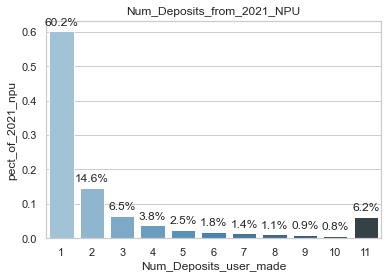

In [153]:
#sns.set_theme(style="whitegrid")
plot = sns.barplot(y= 'pct_of_users', x= 'Num_Depo',
            data = deposit_balance_df_by_user_agg, palette="Blues_d", orient="v");

## add value on top of each bar
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.1%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points');
    
plt.title('Num_Deposits_from_2021_NPU');
plt.xlabel('Num_Deposits_user_made');
plt.ylabel('pect_of_2021_npu');

In [239]:
deposit_balance_df_corr = pd.DataFrame(deposit_balance_df.drop(columns = ['USER_ID','PT_ID','DEP_RNK']))
deposit_balance_df_corr.corr()

,BALANCE_WHEN_DEPOSIT,DEPOSIT,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D
BALANCE_WHEN_DEPOSIT,1.000000,0.175588,0.129460,0.124240,0.165681,0.160521,0.154382,0.204479,0.179359,0.162611
DEPOSIT,0.175588,1.000000,0.448438,0.397265,0.571480,0.571868,0.565318,0.586849,0.555283,0.527408
TOTAL_DEPOSITS,0.129460,0.448438,1.000000,0.956490,0.645419,0.662779,0.677673,0.684091,0.753539,0.803924
TOTAL_ENTRY_FEES,0.124240,0.397265,0.956490,1.000000,0.612401,0.627279,0.641148,0.628858,0.692380,0.741888
AVG_EF_LAST_3D,0.165681,0.571480,0.645419,0.612401,1.000000,0.957231,0.917325,0.769347,0.766716,0.749804
AVG_EF_LAST_7D,0.160521,0.571868,0.662779,0.627279,0.957231,1.000000,0.968264,0.737825,0.774845,0.770482
AVG_EF_LAST_14D,0.154382,0.565318,0.677673,0.641148,0.917325,0.968264,1.000000,0.709776,0.751528,0.778670
AVG_DEPO_LAST_3D,0.204479,0.586849,0.684091,0.628858,0.769347,0.737825,0.709776,1.000000,0.921385,0.858198
AVG_DEPO_LAST_7D,0.179359,0.555283,0.753539,0.692380,0.766716,0.774845,0.751528,0.921385,1.000000,0.949871
AVG_DEPO_LAST_14D,0.162611,0.527408,0.803924,0.741888,0.749804,0.770482,0.778670,0.858198,0.949871,1.000000


In [165]:
from scipy import stats

In [189]:

pearson_coef_D3, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_EF_LAST_3D'])
print("The Pearson Correlation Coefficient for D3_EF is", pearson_coef_D3,
      "with a P-value of P =", p_value)

pearson_coef_D7, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_EF_LAST_7D'])
print("for D7_EF is", pearson_coef_D7,
      "with a P-value of P =", p_value)
pearson_coef_D14, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_EF_LAST_14D'])
print("for D14_EF is", pearson_coef,
      "with a P-value of P =", p_value)
pearson_coef_D3_Depo, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_DEPO_LAST_3D'])
print("for D3_Depo is", pearson_coef_D3_Depo,
      "with a P-value of P =", p_value)

pearson_coef_D7_Depo, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_DEPO_LAST_7D'])
print("for D7_Depo is", pearson_coef_D7_Depo,
      "with a P-value of P =", p_value)
pearson_coef_D14_Depo, p_value = stats.pearsonr(deposit_balance_df_corr['BALANCE_WHEN_DEPOSIT'], deposit_balance_df_corr['AVG_DEPO_LAST_14D'])
print("for D14_Depo is", pearson_coef_D14_Depo,
      "with a P-value of P =", p_value)


The Pearson Correlation Coefficient for D3_EF is 0.16568140196515763 with a P-value of P = 0.0
for D7_EF is 0.1605209726642241 with a P-value of P = 0.0
for D14_EF is 0.15438204397936475 with a P-value of P = 0.0
for D3_Depo is 0.20447920149007084 with a P-value of P = 0.0
for D7_Depo is 0.1793588436083681 with a P-value of P = 0.0
for D14_Depo is 0.16261105559911523 with a P-value of P = 0.0


In [236]:
from datetime import datetime

deposit_balance_df['Account_age'] = datetime.now() - deposit_balance_df.ACCOUNT_CREATION_DATE


In [255]:
deposit_balance_df_by_user.head()

,USER_ID,FIRST_DEPOSIT_DATETIME,Num_Depo,BALANCE_WHEN_DEPOSIT,AVG_EF_LAST_3D,DEPOSIT,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,TOTAL_DEPOSITS,Avg_Deposit_made
USER_ID,,,,,,,,,,,,,
63752992,63752992,2021-01-03 18:39:40,4,1.0125,2.805889,20.0,2.805889,2.805889,50.0,50.0,50.0,80.0,20.0
63753020,63753020,2021-01-04 02:41:05,4,0.1750,1.656706,32.5,1.639933,1.617604,37.5,50.0,62.5,130.0,32.5
63753060,63753060,2021-01-09 03:09:06,2,0.1200,0.000000,3.5,0.119792,0.159792,3.5,3.5,3.5,7.0,3.5
63753084,63753084,2021-01-02 04:53:10,10,0.2650,0.741530,9.2,0.830189,0.843051,10.7,15.7,17.7,92.0,9.2
63753090,63753090,2021-01-01 00:14:28,2,1.5000,0.750000,10.0,0.750000,1.500000,10.0,10.0,10.0,20.0,10.0


In [261]:
deposit_balance_df_by_user_sub_df = pd.DataFrame(deposit_balance_df_by_user.drop(columns = ['USER_ID','DEPOSIT','TOTAL_DEPOSITS','BALANCE_WHEN_DEPOSIT','FIRST_DEPOSIT_DATETIME','AVG_EF_LAST_3D','AVG_EF_LAST_7D','AVG_EF_LAST_14D','AVG_DEPO_LAST_3D','AVG_DEPO_LAST_7D','AVG_DEPO_LAST_14D','TOTAL_DEPOSITS']))
deposit_balance_df_by_user_sub_df.head()


,Num_Depo,Avg_Deposit_made
USER_ID,,
63752992,4,20.0
63753020,4,32.5
63753060,2,3.5
63753084,10,9.2
63753090,2,10.0


In [264]:
deposit_balance_df_0 = pd.merge(left = deposit_balance_df , right = deposit_balance_df_by_user_sub_df, how = "left", on = "USER_ID")

In [268]:
deposit_balance_df_0.sort_values(by=['USER_ID','DATE']).head(155)

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,Account_age,Num_Depo,Avg_Deposit_made
4007156,63752992,5862724515,2021-01-03 18:39:40,0.00,10.0,2021-01-01 00:00:13,2021-01-03 18:39:40,1,80.0,395.70,0.000000,0.000000,0.000000,10.0,10.0,10.0,283 days 17:51:31.819979,4,20.000000
2931137,63752992,5863893209,2021-01-03 21:01:48,1.60,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,2,80.0,395.70,3.600000,3.600000,3.600000,40.0,40.0,40.0,283 days 17:51:31.819979,4,20.000000
705336,63752992,5864080313,2021-01-03 21:24:59,2.20,30.0,2021-01-01 00:00:13,2021-01-03 18:39:40,3,80.0,395.70,3.842308,3.842308,3.842308,70.0,70.0,70.0,283 days 17:51:31.819979,4,20.000000
863926,63752992,5880964791,2021-01-05 14:02:07,0.25,10.0,2021-01-01 00:00:13,2021-01-03 18:39:40,4,80.0,395.70,3.781250,3.781250,3.781250,80.0,80.0,80.0,283 days 17:51:31.819979,4,20.000000
3510209,63753020,5866990926,2021-01-04 02:41:05,0.00,50.0,2021-01-01 00:00:45,2021-01-04 02:41:05,1,130.0,754.85,0.000000,0.000000,0.000000,50.0,50.0,50.0,283 days 17:50:59.819979,4,32.500000
3670270,63753020,5934446259,2021-01-11 02:33:47,0.22,20.0,2021-01-01 00:00:45,2021-01-04 02:41:05,2,130.0,754.85,4.260274,3.748000,3.748000,20.0,70.0,70.0,283 days 17:50:59.819979,4,32.500000
1843564,63753020,5945154039,2021-01-12 04:40:51,0.45,50.0,2021-01-01 00:00:45,2021-01-04 02:41:05,3,130.0,754.85,2.286552,2.731731,2.642416,70.0,70.0,120.0,283 days 17:50:59.819979,4,32.500000
891305,63753020,8068644122,2021-09-02 03:19:06,0.03,10.0,2021-01-01 00:00:45,2021-01-04 02:41:05,4,130.0,754.85,0.080000,0.080000,0.080000,10.0,10.0,10.0,283 days 17:50:59.819979,4,32.500000
3819140,63753060,5915247403,2021-01-09 03:09:06,0.19,2.0,2021-01-01 00:01:24,2021-01-09 03:09:06,1,7.0,93.85,0.000000,0.239583,0.239583,2.0,2.0,2.0,283 days 17:50:20.819979,2,3.500000
1038131,63753060,8409175688,2021-10-02 20:10:55,0.05,5.0,2021-01-01 00:01:24,2021-01-09 03:09:06,2,7.0,93.85,0.000000,0.000000,0.080000,5.0,5.0,5.0,283 days 17:50:20.819979,2,3.500000


<AxesSubplot:xlabel='BALANCE_WHEN_DEPOSIT', ylabel='DEPOSIT'>

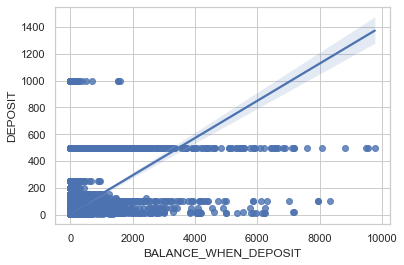

In [273]:
sns.regplot(x="BALANCE_WHEN_DEPOSIT", y="DEPOSIT", data = deposit_balance_df_0)

<AxesSubplot:xlabel='Avg_Deposit_made', ylabel='BALANCE_WHEN_DEPOSIT'>

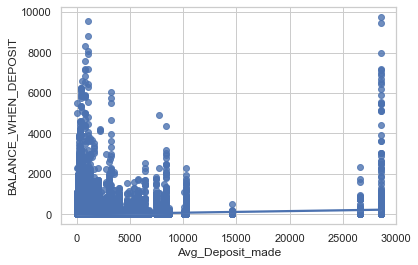

In [274]:
sns.regplot(x="Avg_Deposit_made", y="BALANCE_WHEN_DEPOSIT", data = deposit_balance_df_0)

<AxesSubplot:xlabel='AVG_EF_LAST_3D', ylabel='BALANCE_WHEN_DEPOSIT'>

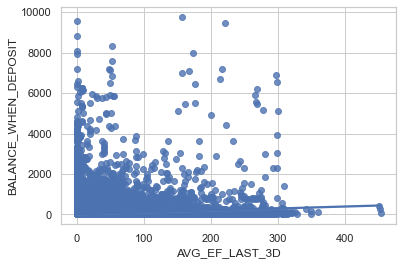

In [275]:
sns.regplot(x="AVG_EF_LAST_3D", y="BALANCE_WHEN_DEPOSIT", data = deposit_balance_df_0)

In [367]:
deposit_balance_df_0[deposit_balance_df_0.DEP_RNK>1].corr()

,USER_ID,PT_ID,BALANCE_WHEN_DEPOSIT,DEPOSIT,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,Num_Depo,Avg_Deposit_made
USER_ID,1.000000,0.709204,-0.001034,-0.038833,-0.153134,-0.075062,-0.062380,-0.042420,-0.046496,-0.049605,-0.024334,-0.028466,-0.032350,-0.148200,-0.074592
PT_ID,0.709204,1.000000,0.004788,0.030698,0.194642,0.023100,0.015134,0.035785,0.042542,0.049155,0.028492,0.034654,0.041348,0.060416,0.022826
BALANCE_WHEN_DEPOSIT,-0.001034,0.004788,1.000000,0.171424,0.027630,0.125954,0.121662,0.159850,0.154328,0.147870,0.200517,0.175255,0.158504,0.011621,0.126104
DEPOSIT,-0.038833,0.030698,0.171424,1.000000,0.162255,0.444046,0.394912,0.562543,0.562323,0.555157,0.581250,0.549764,0.521942,0.120911,0.444419
DEP_RNK,-0.153134,0.194642,0.027630,0.162255,1.000000,0.147805,0.107601,0.195065,0.206768,0.213582,0.164243,0.174635,0.177652,0.738645,0.145227
TOTAL_DEPOSITS,-0.075062,0.023100,0.125954,0.444046,0.147805,1.000000,0.956631,0.643039,0.661353,0.677180,0.681759,0.752046,0.803031,0.109121,0.999987
TOTAL_ENTRY_FEES,-0.062380,0.015134,0.121662,0.394912,0.107601,0.956631,1.000000,0.612719,0.628755,0.643708,0.627551,0.691644,0.741549,0.078217,0.956709
AVG_EF_LAST_3D,-0.042420,0.035785,0.159850,0.562543,0.195065,0.643039,0.612719,1.000000,0.955757,0.914408,0.766060,0.763596,0.746713,0.144570,0.642862
AVG_EF_LAST_7D,-0.046496,0.042542,0.154328,0.562323,0.206768,0.661353,0.628755,0.955757,1.000000,0.966977,0.734133,0.772439,0.768449,0.151533,0.661165
AVG_EF_LAST_14D,-0.049605,0.049155,0.147870,0.555157,0.213582,0.677180,0.643708,0.914408,0.966977,1.000000,0.705634,0.748943,0.777416,0.155089,0.676992


In [368]:
avg_3d_ef = pd.DataFrame(deposit_balance_df_0[deposit_balance_df_0.DEP_RNK>1].AVG_EF_LAST_3D.describe(percentiles=[ .35,.4, .45,.5,.55, .6,.65, .7,.75, .8, .9]).map('{:.6f}'.format) )
avg_3d_ef['AVG_EF_LAST_3D'] = avg_3d_ef.AVG_EF_LAST_3D.astype(float)
avg_3d_ef = avg_3d_ef[(avg_3d_ef.index != 'count') & (avg_3d_ef.index != 'min') & (avg_3d_ef.index != 'mean') &(avg_3d_ef.index != 'max')& (avg_3d_ef.index != 'std')]

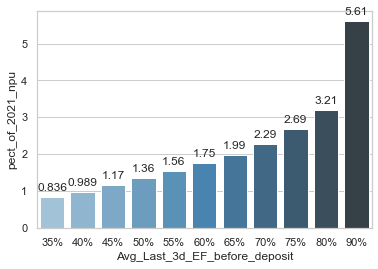

In [369]:
#sns.set_theme(style="whitegrid")
plot2 = sns.barplot(y= 'AVG_EF_LAST_3D', x= avg_3d_ef.index,
            data = avg_3d_ef, palette="Blues_d", orient="v");

## add value on top of each bar
for p in plot2.patches:
    plot2.annotate(format(p.get_height(), '.3'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points');
    
#plt.title('Num_Deposits_from_2021_NPU');
plt.xlabel('Avg_Last_3d_EF_before_deposit');
plt.ylabel('pect_of_2021_npu');

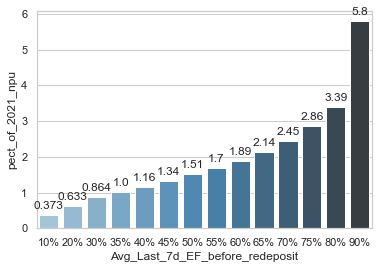

In [374]:
avg_7d_ef = pd.DataFrame(deposit_balance_df_0[deposit_balance_df_0.DEP_RNK>1].AVG_EF_LAST_7D.describe(percentiles=[0.1,0.2,.3, .35,.4, .45,.5,.55, .6,.65, .7,.75, .8, .9]).map('{:.6f}'.format) )
avg_7d_ef['AVG_EF_LAST_7D'] = avg_7d_ef.AVG_EF_LAST_7D.astype(float)
avg_7d_ef = avg_7d_ef[(avg_7d_ef.index != 'count') & (avg_7d_ef.index != 'min') & (avg_7d_ef.index != 'mean') &(avg_7d_ef.index != 'max')& (avg_7d_ef.index != 'std')]
#sns.set_theme(style="whitegrid")

plot_7d = sns.barplot(y= 'AVG_EF_LAST_7D', x= avg_7d_ef.index,
            data = avg_7d_ef, palette="Blues_d", orient="v");

## add value on top of each bar
for p in plot_7d.patches:
    plot_7d.annotate(format(p.get_height(), '.3'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points');
    
#plt.title('Num_Deposits_from_2021_NPU');
plt.xlabel('Avg_Last_7d_EF_before_redeposit');
plt.ylabel('pect_of_2021_npu');

In [310]:
avg_3d_ef

,AVG_EF_LAST_3D
10%,0.0000
20%,0.0000
25%,0.0000
30%,0.0000
35%,0.0000
40%,0.2250
45%,0.2962
50%,0.3677
55%,0.4625
60%,0.5829


In [382]:
deposit_balance_df_0[(deposit_balance_df_0.Avg_Deposit_made>10) & (deposit_balance_df_0.Avg_Deposit_made<=50)].Avg_Deposit_made.describe(percentiles=[.1, .2,.25, .3, .35,.4, .45,.5,.55, .6,.65, .7,.75, .8, .9]).map('{:.6f}'.format) 

count    1399767.000000
mean          23.255851
std           10.634389
min           10.090909
10%           12.000000
20%           13.700000
25%           15.000000
30%           15.363636
35%           16.545455
40%           17.500000
45%           18.888889
50%           20.000000
55%           21.363636
60%           23.181818
65%           25.181818
70%           27.727273
75%           30.000000
80%           32.727273
90%           40.454545
max           50.000000
Name: Avg_Deposit_made, dtype: object

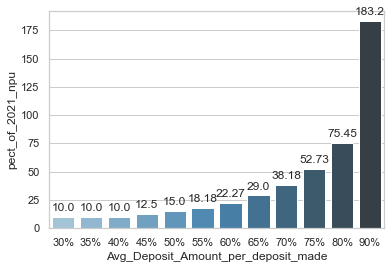

In [376]:
Avg_Deposit_made_df = pd.DataFrame(deposit_balance_df_0.Avg_Deposit_made.describe(percentiles=[.3, .35,.4, .45,.5,.55, .6,.65, .7,.75, .8, .9]).map('{:.6f}'.format) )
Avg_Deposit_made_df['AVG_EF_LAST_7D'] = Avg_Deposit_made_df.Avg_Deposit_made.astype(float)
Avg_Deposit_made_df = Avg_Deposit_made_df[(Avg_Deposit_made_df.index != 'count') & (Avg_Deposit_made_df.index != 'min') & (Avg_Deposit_made_df.index != 'mean') &(Avg_Deposit_made_df.index != 'max')& (Avg_Deposit_made_df.index != 'std')]
#sns.set_theme(style="whitegrid")

plot_depo = sns.barplot(y= 'AVG_EF_LAST_7D', x= Avg_Deposit_made_df.index,
            data = Avg_Deposit_made_df, palette="Blues_d", orient="v");

## add value on top of each bar
for p in plot_depo.patches:
    plot_depo.annotate(format(p.get_height(), '.4'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points');
    
#plt.title('Num_Deposits_from_2021_NPU');
plt.xlabel('Avg_Deposit_Amount_per_deposit_made');
plt.ylabel('pect_of_2021_npu');

In [401]:
### Group Users by their "Last 7d avg EF"

deposit_balance_df_categorized_df =  pd.DataFrame(deposit_balance_df_0)

condition_5 = [
    (deposit_balance_df_categorized_df['Avg_Deposit_made'] <= 10),
    (deposit_balance_df_categorized_df['Avg_Deposit_made'] <= 50), 
    (deposit_balance_df_categorized_df['Avg_Deposit_made'] > 50 )
]
values_5 = ['<=10','10~50','50+']

deposit_balance_df_categorized_df['Avg_Deposit_made_agg'] = np.select(condition_5, values_5)
deposit_balance_df_categorized_df.head()

,USER_ID,PT_ID,DATE,BALANCE_WHEN_DEPOSIT,DEPOSIT,ACCOUNT_CREATION_DATE,FIRST_DEPOSIT_DATETIME,DEP_RNK,TOTAL_DEPOSITS,TOTAL_ENTRY_FEES,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,Account_age,Num_Depo,Avg_Deposit_made,Avg_Deposit_made_agg
0,64052451,6073239322,2021-01-25 15:47:47,0.60,20.0,2021-01-04 00:14:56,2021-01-04 00:25:34,11,1222.0,8920.00,6.164602,4.254450,3.159451,100.0,150.0,260.0,280 days 17:36:48.819979,11,111.090909,50+
1,68781509,6694028496,2021-04-02 05:33:55,3.49,5.0,2021-02-26 11:12:29,2021-02-26 14:47:37,6,147.0,996.25,1.395833,1.072917,0.991379,15.0,30.0,30.0,227 days 06:39:15.819979,11,13.363636,10~50
2,65998812,6287945381,2021-02-17 03:50:40,0.25,20.0,2021-01-25 01:33:23,2021-01-25 02:25:41,11,440.0,2197.80,0.000000,0.584615,0.649693,20.0,20.0,80.0,259 days 16:18:21.819979,11,40.000000,10~50
3,75729580,7425838024,2021-06-25 04:43:11,0.50,5.0,2021-06-07 04:54:48,2021-06-07 04:59:41,8,152.0,971.80,0.696154,0.885068,0.885068,30.0,35.0,35.0,126 days 12:56:56.819979,11,13.818182,10~50
4,80003113,8080399160,2021-09-03 09:54:02,4.00,20.0,2021-07-31 04:04:42,2021-07-31 04:26:02,11,4300.0,37113.80,11.934066,14.953061,17.996491,160.0,440.0,830.0,72 days 13:47:02.819979,11,390.909091,50+


In [426]:
deposit_balance_df_categorized_df_agg = deposit_balance_df_categorized_df.groupby(by=['Avg_Deposit_made_agg']).agg({'USER_ID':'count',
'AVG_EF_LAST_3D':'median','AVG_EF_LAST_7D':'median','AVG_EF_LAST_14D':'median',
'AVG_DEPO_LAST_3D':'median','AVG_DEPO_LAST_7D':'median','AVG_DEPO_LAST_14D':'median','BALANCE_WHEN_DEPOSIT':'mean','Avg_Deposit_made':'median','TOTAL_DEPOSITS':'mean'})


#deposit_balance_df_categorized_df_agg['User_Count'] =deposit_balance_df_categorized_df_agg.groupby(by=['Avg_Deposit_made_agg']).agg({'USER_ID':'nunique'})
deposit_balance_df_categorized_df_agg['pct_user_of_users'] = deposit_balance_df_categorized_df_agg['USER_ID'].transform(lambda x: x/x.sum()).map('{:.4f}'.format)

deposit_balance_df_categorized_df_agg=deposit_balance_df_categorized_df_agg.rename({'USER_ID':'User_Count','BALANCE_WHEN_DEPOSIT':'Avg Balance when Deposit', 'Avg_Deposit_made':'Avg_Deposit_amount_per_deposit'}, axis=1)
#deposit_balance_df_by_7d_deposit_agg.sort_values(by=['pct_user_of_users'], ascending = False)

#balance_when_deposit_agg = balance_when_deposit_agg.append(balance_when_deposit.groupby(by=['Account_Balance_Agg']).agg({'BALANCE_WHEN_DEPOSIT':'mean','AVG_EF_LAST_3D':'mean','DEPOSIT':'mean','AVG_EF_LAST_7D':'mean','AVG_EF_LAST_14D':'mean','DEPOSIT':'mean'})
deposit_balance_df_categorized_df_agg


,User_Count,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,Avg Balance when Deposit,Avg_Deposit_amount_per_deposit,TOTAL_DEPOSITS,pct_user_of_users
Avg_Deposit_made_agg,,,,,,,,,,,
10~50,1399767,0.946154,1.133333,1.226667,20.0,30.0,40.0,2.714567,20.000000,215.035067,0.3350
50+,1072761,2.668085,2.860410,2.934066,60.0,110.0,190.0,7.929830,137.000000,4217.067645,0.2567
<=10,1706060,0.000000,0.000000,0.000000,10.0,10.0,10.0,0.912609,6.727273,25.218203,0.4083


In [432]:
deposit_balance_df_categorized_df_agg=deposit_balance_df_categorized_df_agg[['User_Count','pct_user_of_users', 'Avg_Deposit_amount_per_deposit','AVG_EF_LAST_3D', 'AVG_EF_LAST_7D', 'AVG_EF_LAST_14D',
 'AVG_DEPO_LAST_3D',
 'AVG_DEPO_LAST_7D',
 'AVG_DEPO_LAST_14D',
 'Avg Balance when Deposit',
 'TOTAL_DEPOSITS']]
deposit_balance_df_categorized_df_agg.sort_values(by=['User_Count'], ascending = False)


,User_Count,pct_user_of_users,Avg_Deposit_amount_per_deposit,AVG_EF_LAST_3D,AVG_EF_LAST_7D,AVG_EF_LAST_14D,AVG_DEPO_LAST_3D,AVG_DEPO_LAST_7D,AVG_DEPO_LAST_14D,Avg Balance when Deposit,TOTAL_DEPOSITS
Avg_Deposit_made_agg,,,,,,,,,,,
<=10,1706060,0.4083,6.727273,0.000000,0.000000,0.000000,10.0,10.0,10.0,0.912609,25.218203
10~50,1399767,0.3350,20.000000,0.946154,1.133333,1.226667,20.0,30.0,40.0,2.714567,215.035067
50+,1072761,0.2567,137.000000,2.668085,2.860410,2.934066,60.0,110.0,190.0,7.929830,4217.067645
